# Boulder First Snow

In [1]:
import cftime
import numpy as np
import pandas as pd
import xarray as xr
import proplot as plot
import seaborn as sb

In [2]:
data = pd.read_csv('data/boulder_daily_weather.csv')

In [3]:
# Snow totals do not start until August 1948.
data = data[data.year >= 1948]

In [4]:
datetime = []
for index, row in data.iterrows():
    # ESRL has a leap year every year (Feb 29th) but puts missing data for non
    # leap years. This makes the datetime conversion a little easier.
    datetime.append(cftime.DatetimeAllLeap(row['year'], row['mon'], row['day']))

In [5]:
ds = xr.DataArray(data['snow (in)'], dims=['time'], coords=[datetime]).rename('snow')
# ds['cover'] = ('time', data['snowcover (in)'])

In [6]:
# Get rid of trace amounts or no snow -- convert to NaN.
ds = ds.where(ds >= 0)

No snow has fallen in July or August since 1948. (Showing the total sum inches for each month)

In [7]:
ds.groupby('time.month').sum('time')

<xarray.DataArray 'snow' (month: 12)>
array([ 771.7,  893.3, 1151.4,  865.6,  127.9,    2.3,    0. ,    0. ,
         82.3,  398.6,  862.9,  843.1])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

Can safely find the "first snow" by looking at the September - December range for each year.

In [8]:
def find_first_snow(ds, year):
    """Finds the cftime date of the first snow of the given year."""
    if year == 1989:
        return np.nan
    annual_subset = ds.sel(time=slice(f'{year}-08', f'{year}-12'))
    try:
        idx = (annual_subset > 0).argmax('time')
        cfdate = annual_subset["time"].to_index()[int(idx)]
    except ValueError:
        cfdate = np.nan
    return cfdate

In [9]:
result = [find_first_snow(ds, year) for year in np.arange(1948, 2020)]
result.append(cftime.DatetimeAllLeap(2020, 9, 8))
result = xr.DataArray(result, dims=['year'], coords=[np.arange(1948, 2021)])

In [10]:
# Remove missing data from 1989.
result = result.dropna('year')

In [11]:
# Get the month to separate into colors and dayofyear
# for plotting.
ymonth = result.to_index().month
yday = result.to_index().dayofyear

In [12]:
def plot_snow(ax, x, y, c, s=14, **kwargs):
    """Nice looking scatter plot for each month."""
    p = ax.scatter(x, y, s=s, c=c, zorder=4, 
                   **kwargs)
    return p

/Users/rileybrady/miniconda3/envs/boulder-snow/lib/python3.8/site-packages/proplot/config.py:554: ProPlotWarning: rc setting 'large' was renamed to text.titlesize in version 0.6.
/Users/rileybrady/miniconda3/envs/boulder-snow/lib/python3.8/site-packages/proplot/config.py:554: ProPlotWarning: rc setting 'small' was renamed to text.labelsize in version 0.6.


Text(2022, 282, '     (Oct. 17th)')

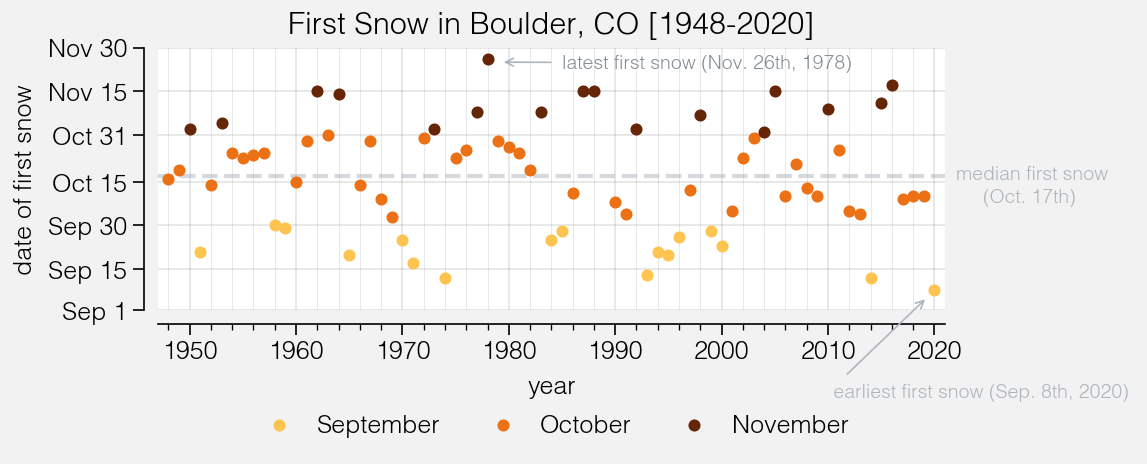

In [15]:
MONTH_COLORS = ['#fec44f', '#ec7014', '#662506']

plot.rc.large = 11
plot.rc.small = 9
plot.rc.fontname = 'Helvetica Light'
plot.rc['legend.frameon'] = False

f, ax = plot.subplots(axwidth='10cm', aspect=3)

x = result.year

p1 = plot_snow(ax, x[ymonth==9], yday[ymonth==9], c=MONTH_COLORS[0], label='September')
p2 = plot_snow(ax, x[ymonth==10], yday[ymonth==10], c=MONTH_COLORS[1], label='October')
p3 = plot_snow(ax, x[ymonth==11], yday[ymonth==11], c=MONTH_COLORS[2], label='November')

# Sep 1 to Nov 30
ylim = [245, 335]

# Sep 1, Sep 15, Sep 30, Oct 15, Oct 31, Nov 15, Nov 30
yticks = [245, 259, 274, 289, 305, 320, 335]
yticklabels = ['Sep 1', 'Sep 15', 'Sep 30', 'Oct 15', 'Oct 31', 'Nov 15', 'Nov 30']

# X limits
xlim=[1947, 2021]

ax.format(xlim=xlim,
          xlocator=10,
          xgridminor=True,
          ylim=ylim,
          yticks=yticks,
          ytickminor=False,
          yticklabels=yticklabels,
          ylabel='date of first snow',
          title='First Snow in Boulder, CO [1948-2020]')

# Latest snow annotation
ax.annotate('latest first snow (Nov. 26th, 1978)', xy=(1979, 330), xytext=(1985, 328),
            fontsize=7, color='gray6',
            arrowprops=dict(arrowstyle='->', facecolor='gray5', edgecolor='gray5'))

# Earliest snow annotation
ax.annotate(' earliest first snow (Sep. 8th, 2020) ', xy=(2019.5, 250), xytext=(2010, 215),
            fontsize=7, color='gray5', 
            arrowprops=dict(arrowstyle='->', facecolor='gray5', edgecolor='gray5',
                            relpos=(0, 0.5)))

# Can this be done through proplot?
sb.despine(offset=5,)

# Legend
ax.legend([p1,p2,p3,], loc='b',
          center=True)

ax.axhline(291, color='gray5', linestyle='--', alpha=0.5, linewidth=1.5)
ax.text(2022, 290, 'median first snow', fontsize=7, color='gray5')
ax.text(2022, 282, '     (Oct. 17th)', fontsize=7, color='gray5')

# f.savefig('figures/first.snow.2020.png')